## Imports

In [ ]:
# !rm -rf glo-flow

In [ ]:
!git clone -b no-sphere https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (281/281), done.
remote: Total 435 (delta 260), reused 310 (delta 140), pack-reused 0
Receiving objects: 100% (435/435), 971.35 KiB | 5.85 MiB/s, done.
Resolving deltas: 100% (260/260), done.


In [ ]:
import sys
sys.path.append('/content/glo-flow')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/glo-flow']

In [ ]:
!pip install -q nflows comet_ml
!pip install -q git+https://github.com/VLL-HD/FrEIA.git

     |████████████████████████████████| 45 kB 1.6 MB/s 
     |████████████████████████████████| 315 kB 20.8 MB/s 
     |████████████████████████████████| 53 kB 728 kB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 548 kB 33.1 MB/s 
     |████████████████████████████████| 38.1 MB 8.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from comet_ml import Experiment
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

from tqdm.notebook import tqdm
from collections import Counter

from modules.dataset import IdxDataset, LatentsDataset, LatentsContextualDataset
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator
from modules.loss import LapLoss, ValLoss
from modules.visualization import img_side_by_side, visualize_image_grid

import FrEIA.framework as Ff
import FrEIA.modules as Fm

In [ ]:
BW_METHOD = 0.1
N_COMPONENTS = 32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Dataset

In [ ]:
dataset_train = IdxDataset(MNIST(root='datasets', train=True, transform=transforms.ToTensor(), download=True))
# subset_idx = torch.randint(low=0, high=len(dataset_train), size=(5_000, ))
# subset = torch.utils.data.Subset(dataset_train, subset_idx)

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(dataset_train, batch_size=64, shuffle=False)
# subset_loader = DataLoader(subset, batch_size=64, shuffle=False)
len(dataset_train) #, len(subset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



60000

In [ ]:
next(iter(train_loader))[1].shape

torch.Size([64, 1, 28, 28])

## Generator

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         latent_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, sample_generator, sparse=True).to(device)

In [ ]:
g_optimizer = torch.optim.Adam(model.generator.parameters(), lr=1e-3)
g_scheduler = None
z_optimizer = torch.optim.SparseAdam(params=model.z.parameters(), lr=1e-3)
z_scheduler = None #torch.optim.lr_scheduler.StepLR(z_optimizer, step_size=130, gamma=0.2)

## Flow model from FrEIA

In [ ]:
def subnet_fc(dims_in, dims_out):
    middle_dim = 256
    fc1 = nn.Linear(dims_in, middle_dim)
    torch.nn.init.xavier_normal_(fc1.weight)
    fc2 = nn.Linear(middle_dim, dims_out)
    torch.nn.init.zeros_(fc2.weight)
    
    return nn.Sequential(fc1, nn.ReLU(), fc2)

In [ ]:
N = 100
flow = Ff.SequenceINN(N_COMPONENTS)
for k in range(N):
    flow.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)
    if k < N-1:
        flow.append(Fm.PermuteRandom) #inn.append(Fm.OrthogonalTransform)
_ = flow.to(device)

In [ ]:
flow_optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
flow_scheduler = None #torch.optim.lr_scheduler.MultiStepLR(flow_optimizer, [50, 100], gamma=0.2)

## Training pipeline

In [ ]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='joint-mnist',
                        workspace='alexandernevarko',
                        auto_metric_logging=False)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/joint-mnist/3f29ae58ff9d4265bbf0a330a79aacf2
COMET INFO:   Metrics:
COMET INFO:     Train flow loss      : 0.02383599802851677
COMET INFO:     Train generator loss : 0.1889638900756836
COMET INFO:   Others:
COMET INFO:     Name         : no_sphere_alpha_0.9
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1vPg53Uz_QxR-7dxw_R0Q8A6TK6namvfn
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: As you ar

In [ ]:
g_criterion = LapLoss(max_levels=2, channels=1, device=device)
val_loss = ValLoss(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
from torchvision.utils import make_grid, save_image

def img_raw_by_raw(*imgs, inv_transform=None, save_file=None):
    '''
    Visualize two pairs of image tensor sets
    imgs: tensors array with shapes B x C x H x W
    inv_transform: inverse transform for tensor -> image transformation
        default: torchvision.transforms.ToPILImage() 
    save_file: str, file name to save images. If None, don't save images.
        default: None
    '''
    if inv_transform is None:
        inv_transform = transforms.ToPILImage()
    grids = []
    for img in imgs:
        img = img.detach().cpu()
        grid = (make_grid(img, nrow=len(img), padding=1))
        grids.append(grid)
    
    tuples = torch.empty(len(imgs), *grids[0].shape, dtype=torch.float32)
    for i in range(len(tuples)):
        tuples[i] = grids[i]
    grid = make_grid(tuples, nrow=1, padding=1)
    if save_file is not None:
        save_image(grid, save_file)
    return inv_transform(grid)

def balanced_alpha(flow_grad, gen_grad):
    flow_grad_mean_norm = torch.sqrt(torch.sum(flow_grad ** 2, dim=1)).mean()
    gen_grad_mean_norm = torch.sqrt(torch.sum(gen_grad ** 2, dim=1)).mean()
    alpha = gen_grad_mean_norm / (gen_grad_mean_norm + flow_grad_mean_norm)
    return alpha

In [ ]:
# experiment = None

def bad_loss(loss):
    return (loss > 10) or torch.isnan(loss) or torch.isinf(loss)

exp_name = 'no_sphere_alpha_0.9'
model_path = '/content/drive/MyDrive/GLANN/joint_mnist_models'
n_epochs = 501
if experiment is not None:
    experiment.set_name(exp_name)
img_num = 16 # number of images to log
alpha = 0.9 # Factor of flow gradient
cnt = Counter()
clipping_value = 1e-4 # for gradient clipping
best_epoch_loss = np.inf

for epoch in tqdm(range(n_epochs)):
    flow.train()
    model.train()
    gen_running_loss = []
    flow_running_loss = []
    for i, (idx, img, _) in enumerate(tqdm(train_loader, leave=False)):
        idx, img = idx.long().to(device), img.float().to(device)
        
        g_optimizer.zero_grad()
        z_optimizer.zero_grad()
        flow_optimizer.zero_grad()
        # Generator forward pass
        preds = model(idx=idx)
        loss = g_criterion(preds, img)
        loss.backward(retain_graph=True)
        g_optimizer.step()
        # Save Z gradient from generator and zero it on Z parameter
        gen_z_grad = model.z.weight.grad.detach()
        model.z.weight.grad.zero_()
        # Flow forward pass
        noise = torch.randn_like(model.z(idx), device=device).float() * 1e-2 # For flow stability
        normal_z, log_jac_det = flow(model.z(idx) + noise)
        flow_loss = 0.5 * torch.sum(normal_z**2, 1) - log_jac_det
        flow_loss = flow_loss.mean() / N_COMPONENTS
        if bad_loss(flow_loss):
            print(f'Bad loss {flow_loss} occured here: epoch - {epoch}, iteration - {i}')
            z_optimizer.step()
            continue
        flow_loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), clipping_value)
        flow_optimizer.step()
        
        # Save Z gradient from flow and zero it on Z parameter
        flow_z_grad = model.z.weight.grad.detach()
        model.z.weight.grad.zero_()

        # Reconstruct the Z gradient summing the two gradients from generator and flow
        # alpha = balanced_alpha(flow_z_grad.to_dense()[idx], gen_z_grad.to_dense()[idx])
        model.z.weight.grad = alpha*flow_z_grad + (1-alpha)*gen_z_grad
        z_optimizer.step()
        
        # Log metrics
        gen_running_loss.append(loss.item())
        flow_running_loss.append(flow_loss.item())
        if experiment is not None:
            experiment.log_metric(f'Train generator loss', loss.item(), epoch=epoch, step=cnt['train'])
            experiment.log_metric(f'Train flow loss', flow_loss.item(), epoch=epoch, step=cnt['train'])
            # experiment.log_metric(f'Alpha', alpha.item(), epoch=epoch, step=cnt['train'])
        cnt['train'] += 1

    if g_scheduler is not None:
        g_scheduler.step()
    if z_scheduler is not None:
        z_scheduler.step()
    if flow_scheduler is not None:
        flow_scheduler.step()

    # Log metrics and images
    gen_epoch_loss = np.mean(gen_running_loss)
    flow_epoch_loss = np.mean(flow_running_loss)
    print(f'Average generator epoch {epoch} train loss: {gen_epoch_loss}')
    print(f'Average flow epoch {epoch} train loss: {flow_epoch_loss}')
    if experiment is not None:
        experiment.log_metric(f'Average generator epoch train loss', gen_epoch_loss, epoch=epoch, step=epoch)
        experiment.log_metric(f'Average flow epoch train loss', flow_epoch_loss, epoch=epoch, step=epoch)
        
        model.eval()
        flow.eval()
        normal_samples = torch.randn(img_num, N_COMPONENTS).to(device)
        random_idx = torch.randint(low=0, high=len(model.z.weight), size=(img_num,), device=device)

        flow_samples, _ = flow(normal_samples, rev=True)
        flow_imgs = model(inputs=flow_samples)
        fit_imgs = model(idx=random_idx)
        train_imgs = torch.stack([train_loader.dataset[i][1].detach().cpu() for i in random_idx])
        if len(train_imgs.shape) == 3:
            train_imgs = train_imgs.unsqueeze(1)
        experiment.log_image(img_raw_by_raw(train_imgs, fit_imgs, flow_imgs), 
                             name=f'Epoch {epoch}', step=epoch, )
            
        if epoch % 10 == 0:
            print(f'Calculating FID on epoch {epoch}')
            # FrEIA package
            def inputs_generator(size):
                normal_sample = torch.randn(size, N_COMPONENTS).to(device)
                fake_lats, _ = flow(normal_sample, rev=True)
                return fake_lats

            fid, inception_score = val_loss(model, train_loader, inputs_generator)
            print(f'FID: {fid}, IS: {inception_score}')
            if np.isnan(fid) or np.isnan(inception_score):
                print(f'Bad FID {fid} or IS {inception_score}')
                fid = 16.0
                inception_score = 2.45
            experiment.log_metric(f'FID', fid, epoch=epoch, step=epoch)
            experiment.log_metric(f'IS', inception_score, epoch=epoch, step=epoch)
                
    if gen_epoch_loss < best_epoch_loss:
        best_epoch_loss = gen_epoch_loss
        torch.save(model.state_dict(), os.path.join(model_path, f'{exp_name}_generator_model.pth'))
        torch.save(flow.state_dict(), os.path.join(model_path, f'{exp_name}_flow_model.pth'))

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Bad loss 209901617152.0 occured here: epoch - 0, iteration - 553
Average generator epoch 0 train loss: 0.060714822850938543
Average flow epoch 0 train loss: -1.7677505873461734
Calculating FID on epoch 0


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 29.00387929690433, IS: 2.38847279548645


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 1 train loss: 0.039346741432987296
Average flow epoch 1 train loss: -2.011105650650667


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 2 train loss: 0.03726357434278549
Average flow epoch 2 train loss: -2.106474753508944


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 3 train loss: 0.036522968646401026
Average flow epoch 3 train loss: -2.1836901438007477


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 4 train loss: 0.036360663612053465
Average flow epoch 4 train loss: -2.250607247545775


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 5 train loss: 0.03654783625386036
Average flow epoch 5 train loss: -2.3092613870909475


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 6 train loss: 0.03699917307715299
Average flow epoch 6 train loss: -2.3608465273497203


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 7 train loss: 0.037582681242273305
Average flow epoch 7 train loss: -2.408256333519909


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 8 train loss: 0.03824327138266457
Average flow epoch 8 train loss: -2.4513761547328565


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 9 train loss: 0.03891860784243927
Average flow epoch 9 train loss: -2.489624113162189


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 10 train loss: 0.039635969889856605
Average flow epoch 10 train loss: -2.5259752309144434
Calculating FID on epoch 10


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 21.011520529456607, IS: 2.526606321334839


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 11 train loss: 0.0402955212024674
Average flow epoch 11 train loss: -2.5590389278143455


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 12 train loss: 0.040968949324699605
Average flow epoch 12 train loss: -2.588734916278294


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 13 train loss: 0.04154955803045332
Average flow epoch 13 train loss: -2.616376662305169


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 14 train loss: 0.0421098629270853
Average flow epoch 14 train loss: -2.6425372316384874


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 15 train loss: 0.042660508741702095
Average flow epoch 15 train loss: -2.668278717028815


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 16 train loss: 0.04308460342652127
Average flow epoch 16 train loss: -2.6919471183057024


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 17 train loss: 0.0435566521847426
Average flow epoch 17 train loss: -2.712958098982951


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 18 train loss: 0.043982218085194445
Average flow epoch 18 train loss: -2.7338781793996976


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 19 train loss: 0.04437844315841635
Average flow epoch 19 train loss: -2.7540882960565565


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 20 train loss: 0.04471212129460088
Average flow epoch 20 train loss: -2.773548553493231
Calculating FID on epoch 20


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 25.910329372345267, IS: 2.5561206340789795


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 21 train loss: 0.04510254771121021
Average flow epoch 21 train loss: -2.7907211221357398


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 22 train loss: 0.04538844142959062
Average flow epoch 22 train loss: -2.806725595043158


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 23 train loss: 0.04571427684873025
Average flow epoch 23 train loss: -2.823224103272851


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 24 train loss: 0.04598871065673035
Average flow epoch 24 train loss: -2.8370447006306923


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 25 train loss: 0.04627116394243134
Average flow epoch 25 train loss: -2.853031379327591


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 26 train loss: 0.04655726086785163
Average flow epoch 26 train loss: -2.8656717688798397


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 27 train loss: 0.04677981762950227
Average flow epoch 27 train loss: -2.878782681818964


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 28 train loss: 0.047067190856059225
Average flow epoch 28 train loss: -2.8912195854349685


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 29 train loss: 0.047315363523993154
Average flow epoch 29 train loss: -2.904813594401264


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 30 train loss: 0.04751140372092917
Average flow epoch 30 train loss: -2.9151145420603153
Calculating FID on epoch 30


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 29.846033622002814, IS: 2.566117525100708


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 31 train loss: 0.04775538145780945
Average flow epoch 31 train loss: -2.925733544933262


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 32 train loss: 0.04796857110012188
Average flow epoch 32 train loss: -2.936922811495978


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 33 train loss: 0.04818587806194957
Average flow epoch 33 train loss: -2.9455277393621677


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 34 train loss: 0.0483856544788204
Average flow epoch 34 train loss: -2.9548543696718683


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 35 train loss: 0.04859905421479679
Average flow epoch 35 train loss: -2.963802442621829


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 36 train loss: 0.048797358121317844
Average flow epoch 36 train loss: -2.972409093812076


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 37 train loss: 0.0489924373125026
Average flow epoch 37 train loss: -2.9821298300330317


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 38 train loss: 0.04918593284227192
Average flow epoch 38 train loss: -2.9905599696295604


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 39 train loss: 0.049340808180285925
Average flow epoch 39 train loss: -2.9981018406495865


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 40 train loss: 0.04954707100669713
Average flow epoch 40 train loss: -3.0066308283856684
Calculating FID on epoch 40


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 31.64460316962584, IS: 2.5873565673828125


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 41 train loss: 0.049706816859940474
Average flow epoch 41 train loss: -3.0124571839375283


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 42 train loss: 0.04987037051985386
Average flow epoch 42 train loss: -3.020504605032996


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 43 train loss: 0.0500562687569272
Average flow epoch 43 train loss: -3.0270767173787423


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 44 train loss: 0.05021678551094237
Average flow epoch 44 train loss: -3.032778230303132


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 45 train loss: 0.05040538441667806
Average flow epoch 45 train loss: -3.0404301431895826


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 46 train loss: 0.05056180353405506
Average flow epoch 46 train loss: -3.0470815708896497


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 47 train loss: 0.05070980275665392
Average flow epoch 47 train loss: -3.0528552565239133


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 48 train loss: 0.05086700252886774
Average flow epoch 48 train loss: -3.059934756903252


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 49 train loss: 0.05103015571213099
Average flow epoch 49 train loss: -3.064527829572844


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 50 train loss: 0.05118761147692132
Average flow epoch 50 train loss: -3.069645477256287
Calculating FID on epoch 50


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 34.17425829770896, IS: 2.5718703269958496


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 51 train loss: 0.05135081674673283
Average flow epoch 51 train loss: -3.0754803342859884


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 52 train loss: 0.0515018959345022
Average flow epoch 52 train loss: -3.0807440163992617


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 53 train loss: 0.05163742533164111
Average flow epoch 53 train loss: -3.0847045434817577


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 54 train loss: 0.05177633777292553
Average flow epoch 54 train loss: -3.090607094612203


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 55 train loss: 0.05193618227487434
Average flow epoch 55 train loss: -3.0955426570957405


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 56 train loss: 0.0520746086769775
Average flow epoch 56 train loss: -3.101200064870594


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 57 train loss: 0.05221293515948726
Average flow epoch 57 train loss: -3.10530302951585


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 58 train loss: 0.05237665391568817
Average flow epoch 58 train loss: -3.110352053062748


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 59 train loss: 0.052493401685916284
Average flow epoch 59 train loss: -3.1139967680485774


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 60 train loss: 0.05265759471367036
Average flow epoch 60 train loss: -3.1191568466137722
Calculating FID on epoch 60


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 33.87145464479467, IS: 2.6134192943573


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 61 train loss: 0.05277572933242901
Average flow epoch 61 train loss: -3.1228374191947075


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 62 train loss: 0.05291142180037778
Average flow epoch 62 train loss: -3.1273741948324987


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 63 train loss: 0.05304641757152482
Average flow epoch 63 train loss: -3.131416650723293


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 64 train loss: 0.05318134512776124
Average flow epoch 64 train loss: -3.134760698529957


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 65 train loss: 0.05329454917786345
Average flow epoch 65 train loss: -3.138903695128874


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 66 train loss: 0.053434104489873464
Average flow epoch 66 train loss: -3.142627210505227


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 67 train loss: 0.053531434800007195
Average flow epoch 67 train loss: -3.145377014999959


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 68 train loss: 0.053677890302815924
Average flow epoch 68 train loss: -3.149327482495989


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 69 train loss: 0.05378794114091503
Average flow epoch 69 train loss: -3.152263794118153


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 70 train loss: 0.053907904781893626
Average flow epoch 70 train loss: -3.1557083676364632
Calculating FID on epoch 70


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 35.16412192903085, IS: 2.5891098976135254


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 71 train loss: 0.05401540693761443
Average flow epoch 71 train loss: -3.1595955606716783


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 72 train loss: 0.054150279190367474
Average flow epoch 72 train loss: -3.162697859918639


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 73 train loss: 0.0542453048325805
Average flow epoch 73 train loss: -3.1662986565754614


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 74 train loss: 0.054347133057426285
Average flow epoch 74 train loss: -3.16931750474454


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 75 train loss: 0.054466276939934506
Average flow epoch 75 train loss: -3.172999476573106


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 76 train loss: 0.05458067549761933
Average flow epoch 76 train loss: -3.175893520749708


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 77 train loss: 0.05467643690452393
Average flow epoch 77 train loss: -3.178909277865119


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 78 train loss: 0.05478166551319267
Average flow epoch 78 train loss: -3.1816874808594107


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 79 train loss: 0.054887738031174325
Average flow epoch 79 train loss: -3.1857990565330487


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 80 train loss: 0.05501054091525993
Average flow epoch 80 train loss: -3.187592115991914
Calculating FID on epoch 80


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 34.575172018235854, IS: 2.5985310077667236


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 81 train loss: 0.055083779773033505
Average flow epoch 81 train loss: -3.190174688916725


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 82 train loss: 0.055188600867510096
Average flow epoch 82 train loss: -3.1929521057397316


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 83 train loss: 0.05530523602117989
Average flow epoch 83 train loss: -3.196287193023828


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 84 train loss: 0.05538101748489876
Average flow epoch 84 train loss: -3.1982322283136817


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 85 train loss: 0.05548940835270419
Average flow epoch 85 train loss: -3.20051487524118


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 86 train loss: 0.05555913958754113
Average flow epoch 86 train loss: -3.2032099143782657


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 87 train loss: 0.05565618208921286
Average flow epoch 87 train loss: -3.2058389265654186


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 88 train loss: 0.055765823459129595
Average flow epoch 88 train loss: -3.2102500129101883


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 89 train loss: 0.05584806489394799
Average flow epoch 89 train loss: -3.2109341074917106


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 90 train loss: 0.055939582805993204
Average flow epoch 90 train loss: -3.2145578393549807
Calculating FID on epoch 90


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 36.02314403704614, IS: 2.5816152095794678


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 91 train loss: 0.05601205716112148
Average flow epoch 91 train loss: -3.2168429734101935


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 92 train loss: 0.0561133713793081
Average flow epoch 92 train loss: -3.2193304691741718


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 93 train loss: 0.05621524014547944
Average flow epoch 93 train loss: -3.220467209307624


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 94 train loss: 0.05630443690380435
Average flow epoch 94 train loss: -3.223045573814083


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 95 train loss: 0.05634874047469229
Average flow epoch 95 train loss: -3.2252269978208075


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 96 train loss: 0.05646763330520089
Average flow epoch 96 train loss: -3.227827012411821


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 97 train loss: 0.05657416669083938
Average flow epoch 97 train loss: -3.22943597155085


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 98 train loss: 0.05664936482096151
Average flow epoch 98 train loss: -3.2322306993927783


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 99 train loss: 0.05673010379218979
Average flow epoch 99 train loss: -3.2342741624124525


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 100 train loss: 0.056846996094149824
Average flow epoch 100 train loss: -3.236895090735543
Calculating FID on epoch 100


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 36.15506453164234, IS: 2.6661319732666016


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 101 train loss: 0.05691045456762507
Average flow epoch 101 train loss: -3.238869000345405


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 102 train loss: 0.056996177941528975
Average flow epoch 102 train loss: -3.240128828518426


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 103 train loss: 0.05709626984748759
Average flow epoch 103 train loss: -3.2418096434078745


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 104 train loss: 0.05716755298345582
Average flow epoch 104 train loss: -3.2446284525430023


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 105 train loss: 0.0572520976127592
Average flow epoch 105 train loss: -3.246254062093397


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 106 train loss: 0.05732636522255473
Average flow epoch 106 train loss: -3.2481317850572466


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 107 train loss: 0.05739843812800928
Average flow epoch 107 train loss: -3.249734969281439


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 108 train loss: 0.057489175003951294
Average flow epoch 108 train loss: -3.2520730660668313


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 109 train loss: 0.05757237091136258
Average flow epoch 109 train loss: -3.254206862530983


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 110 train loss: 0.05765918855950522
Average flow epoch 110 train loss: -3.256838858000505
Calculating FID on epoch 110


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 34.98504145072182, IS: 2.589956283569336


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 111 train loss: 0.05772233184085472
Average flow epoch 111 train loss: -3.2584620160080475


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 112 train loss: 0.057800676256640635
Average flow epoch 112 train loss: -3.2592639142770503


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 113 train loss: 0.057874568080755945
Average flow epoch 113 train loss: -3.261703186706185


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 114 train loss: 0.0579767345405146
Average flow epoch 114 train loss: -3.2635837592549923


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 115 train loss: 0.05802537609678087
Average flow epoch 115 train loss: -3.2651276519811994


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 116 train loss: 0.058113200836249
Average flow epoch 116 train loss: -3.2676738035450104


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 117 train loss: 0.05818254541931376
Average flow epoch 117 train loss: -3.269143599945345


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 118 train loss: 0.058259181257313504
Average flow epoch 118 train loss: -3.2698443998405926


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 119 train loss: 0.05831069787189778
Average flow epoch 119 train loss: -3.2729201947193918


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 120 train loss: 0.0583823978829422
Average flow epoch 120 train loss: -3.2736308561967635
Calculating FID on epoch 120


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 35.71521334101615, IS: 2.6164066791534424


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 121 train loss: 0.058462087799713555
Average flow epoch 121 train loss: -3.276106869742306


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 122 train loss: 0.05852747974254048
Average flow epoch 122 train loss: -3.277042935397833


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 123 train loss: 0.05861947779208104
Average flow epoch 123 train loss: -3.2802521920661682


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 124 train loss: 0.058673901491359606
Average flow epoch 124 train loss: -3.280387220352189


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 125 train loss: 0.058748480615648885
Average flow epoch 125 train loss: -3.2824727934814972


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 126 train loss: 0.05881214242325281
Average flow epoch 126 train loss: -3.282940840416117


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 127 train loss: 0.058894299066015905
Average flow epoch 127 train loss: -3.2849103741045953


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 128 train loss: 0.05893914532591539
Average flow epoch 128 train loss: -3.2854556790801253


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 129 train loss: 0.05902974411988182
Average flow epoch 129 train loss: -3.287998503459288


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 130 train loss: 0.05910006236991903
Average flow epoch 130 train loss: -3.2899398531740918
Calculating FID on epoch 130


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 35.00219448765311, IS: 2.6279397010803223


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 131 train loss: 0.059166191503214935
Average flow epoch 131 train loss: -3.291448006751949


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 132 train loss: 0.05925093192472133
Average flow epoch 132 train loss: -3.294158868698169


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 133 train loss: 0.05932139370566619
Average flow epoch 133 train loss: -3.2942787482540234


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 134 train loss: 0.0593658270739289
Average flow epoch 134 train loss: -3.2954552786182494


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 135 train loss: 0.059431231316568245
Average flow epoch 135 train loss: -3.297468967529248


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 136 train loss: 0.05952096952876048
Average flow epoch 136 train loss: -3.2991209993484434


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 137 train loss: 0.05957727354647381
Average flow epoch 137 train loss: -3.301303627140232


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 138 train loss: 0.059666795691828735
Average flow epoch 138 train loss: -3.3009411259246533


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 139 train loss: 0.05971256695560682
Average flow epoch 139 train loss: -3.3033418950241513


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 140 train loss: 0.05977801910277877
Average flow epoch 140 train loss: -3.3046915259188427
Calculating FID on epoch 140


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 36.19476702668206, IS: 2.6266210079193115


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 141 train loss: 0.059851900168033295
Average flow epoch 141 train loss: -3.3056314011880836


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 142 train loss: 0.059903011921404015
Average flow epoch 142 train loss: -3.307822734308141


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 143 train loss: 0.05998354356314963
Average flow epoch 143 train loss: -3.3086094093729437


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 144 train loss: 0.06003428982900404
Average flow epoch 144 train loss: -3.310073067638666


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 145 train loss: 0.060105902899398225
Average flow epoch 145 train loss: -3.3099958807674805


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 146 train loss: 0.06013712056203565
Average flow epoch 146 train loss: -3.3119447424467694


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 147 train loss: 0.06022173161112042
Average flow epoch 147 train loss: -3.313837166788227


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 148 train loss: 0.06027176143772312
Average flow epoch 148 train loss: -3.3150648290414546


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 149 train loss: 0.06035162822238164
Average flow epoch 149 train loss: -3.3167435660291074


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 150 train loss: 0.06040225778100714
Average flow epoch 150 train loss: -3.3174812999615537
Calculating FID on epoch 150


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 36.86110004882816, IS: 2.6029140949249268


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 151 train loss: 0.060452678215020754
Average flow epoch 151 train loss: -3.3191490531730246


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 152 train loss: 0.060516730058136015
Average flow epoch 152 train loss: -3.319461619676049


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 153 train loss: 0.06058033828192683
Average flow epoch 153 train loss: -3.321849115367637


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 154 train loss: 0.06065597372459196
Average flow epoch 154 train loss: -3.322754116454867


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 155 train loss: 0.06067902771537619
Average flow epoch 155 train loss: -3.32359802290829


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 156 train loss: 0.06072840321737566
Average flow epoch 156 train loss: -3.3255311021926817


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 157 train loss: 0.060816653025175714
Average flow epoch 157 train loss: -3.3268129774756523


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 158 train loss: 0.06086901270313812
Average flow epoch 158 train loss: -3.3265141037735604


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 159 train loss: 0.06093749195448498
Average flow epoch 159 train loss: -3.3293014691074267


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 160 train loss: 0.06099412163723506
Average flow epoch 160 train loss: -3.3291672869786018
Calculating FID on epoch 160


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 38.988944224379054, IS: 2.6651625633239746


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 161 train loss: 0.06103129940691279
Average flow epoch 161 train loss: -3.3306077467098927


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 162 train loss: 0.06112203404688632
Average flow epoch 162 train loss: -3.3324558440047793


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 163 train loss: 0.06115225364547421
Average flow epoch 163 train loss: -3.3322484462754303


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 164 train loss: 0.0612050783254508
Average flow epoch 164 train loss: -3.3327482837095443


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 165 train loss: 0.06127967384816614
Average flow epoch 165 train loss: -3.3357762471953434


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 166 train loss: 0.06134842909666013
Average flow epoch 166 train loss: -3.336974330294107


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 167 train loss: 0.06138713193187582
Average flow epoch 167 train loss: -3.336657638997157


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 168 train loss: 0.06143420319090774
Average flow epoch 168 train loss: -3.339230143947642


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 169 train loss: 0.061504917473458785
Average flow epoch 169 train loss: -3.3390479776650857


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 170 train loss: 0.06156235678729091
Average flow epoch 170 train loss: -3.3410566951166083
Calculating FID on epoch 170


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.390072499188484, IS: 2.6535377502441406


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 171 train loss: 0.06161089164457087
Average flow epoch 171 train loss: -3.342303669274743


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 172 train loss: 0.06166811664300814
Average flow epoch 172 train loss: -3.342633145196097


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 173 train loss: 0.061723588896331505
Average flow epoch 173 train loss: -3.344274670584624


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 174 train loss: 0.06177759440993068
Average flow epoch 174 train loss: -3.345653111238215


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 175 train loss: 0.06182086494352136
Average flow epoch 175 train loss: -3.3469557701143375


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 176 train loss: 0.061879316738038176
Average flow epoch 176 train loss: -3.3484883791348063


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 177 train loss: 0.061941873754805594
Average flow epoch 177 train loss: -3.3489499938513423


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 178 train loss: 0.06198533975096272
Average flow epoch 178 train loss: -3.348820077585005


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 179 train loss: 0.06202659999399678
Average flow epoch 179 train loss: -3.3498249785986536


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 180 train loss: 0.062092953995029045
Average flow epoch 180 train loss: -3.35101706005617
Calculating FID on epoch 180


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.11600192174665, IS: 2.6402931213378906


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 181 train loss: 0.062141005938717804
Average flow epoch 181 train loss: -3.352485959972146


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 182 train loss: 0.06218647763434885
Average flow epoch 182 train loss: -3.3543785975686014


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 183 train loss: 0.062224526613601235
Average flow epoch 183 train loss: -3.3542229143032896


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 184 train loss: 0.06227169276824765
Average flow epoch 184 train loss: -3.3555739144526564


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 185 train loss: 0.062332035814807105
Average flow epoch 185 train loss: -3.3572209328730733


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 186 train loss: 0.06237808070870351
Average flow epoch 186 train loss: -3.358110364820403


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 187 train loss: 0.06244569167351799
Average flow epoch 187 train loss: -3.3588356699770703


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 188 train loss: 0.06250506325730129
Average flow epoch 188 train loss: -3.359598750752935


  0%|          | 0/938 [00:00<?, ?it/s]

Bad loss inf occured here: epoch - 189, iteration - 903
Average generator epoch 189 train loss: 0.06254220929239324
Average flow epoch 189 train loss: -3.3602445018711316


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 190 train loss: 0.06259252592873599
Average flow epoch 190 train loss: -3.3627018654016037
Calculating FID on epoch 190


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.05648075488332, IS: 2.6479508876800537


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 191 train loss: 0.06265197501682651
Average flow epoch 191 train loss: -3.3617121057469705


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 192 train loss: 0.06269545746701104
Average flow epoch 192 train loss: -3.363436036780953


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 193 train loss: 0.06273802315820255
Average flow epoch 193 train loss: -3.3641787337850153


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 194 train loss: 0.0628028267911121
Average flow epoch 194 train loss: -3.365194745663641


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 195 train loss: 0.06285887026885298
Average flow epoch 195 train loss: -3.3669087691093558


  0%|          | 0/938 [00:00<?, ?it/s]

Bad loss inf occured here: epoch - 196, iteration - 639
Average generator epoch 196 train loss: 0.06290768280529925
Average flow epoch 196 train loss: -3.3669370485344463


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 197 train loss: 0.06294327755091286
Average flow epoch 197 train loss: -3.3671260424005958


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 198 train loss: 0.06301465466507335
Average flow epoch 198 train loss: -3.3680825876528773


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 199 train loss: 0.06304781967754176
Average flow epoch 199 train loss: -3.3702253037170053


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 200 train loss: 0.06309716284735752
Average flow epoch 200 train loss: -3.371563828576094
Calculating FID on epoch 200


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.95613790939925, IS: 2.6229052543640137


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 201 train loss: 0.0631467279221521
Average flow epoch 201 train loss: -3.3717586473107084


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 202 train loss: 0.06319510621000836
Average flow epoch 202 train loss: -3.3725682781703434


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 203 train loss: 0.06323462546364203
Average flow epoch 203 train loss: -3.3729260079642094


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 204 train loss: 0.063269415250751
Average flow epoch 204 train loss: -3.374140521864901


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 205 train loss: 0.06335096633923587
Average flow epoch 205 train loss: -3.3755680533614494


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 206 train loss: 0.06337057686706724
Average flow epoch 206 train loss: -3.3759259539626556


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 207 train loss: 0.06341324600853773
Average flow epoch 207 train loss: -3.3778317444868433


  0%|          | 0/938 [00:00<?, ?it/s]

Bad loss inf occured here: epoch - 208, iteration - 670
Average generator epoch 208 train loss: 0.06342568624617578
Average flow epoch 208 train loss: -3.3776349415774023


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 209 train loss: 0.06351070746636467
Average flow epoch 209 train loss: -3.3790971643126597


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 210 train loss: 0.06353978645890507
Average flow epoch 210 train loss: -3.379183366100417
Calculating FID on epoch 210


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 38.86018276143109, IS: 2.6450934410095215


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 211 train loss: 0.06360311646546636
Average flow epoch 211 train loss: -3.379664280012981


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 212 train loss: 0.06362315258587092
Average flow epoch 212 train loss: -3.3819401630206403


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 213 train loss: 0.06368067815725102
Average flow epoch 213 train loss: -3.382056503407737


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 214 train loss: 0.06371366292206464
Average flow epoch 214 train loss: -3.3828592778268907


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 215 train loss: 0.06376422480987842
Average flow epoch 215 train loss: -3.3838688976474915


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 216 train loss: 0.06379196062874692
Average flow epoch 216 train loss: -3.38493809974524


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 217 train loss: 0.06382642093021224
Average flow epoch 217 train loss: -3.3848381350035353


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 218 train loss: 0.06389301600677372
Average flow epoch 218 train loss: -3.3854153097819673


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 219 train loss: 0.06393531693626187
Average flow epoch 219 train loss: -3.385494129998343


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 220 train loss: 0.06394817483927141
Average flow epoch 220 train loss: -3.3876293239308826
Calculating FID on epoch 220


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 38.27644426348004, IS: 2.674182653427124


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 221 train loss: 0.06402265561669111
Average flow epoch 221 train loss: -3.389188058594905


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 222 train loss: 0.06408048220979634
Average flow epoch 222 train loss: -3.3893280659657297


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 223 train loss: 0.06409697207227064
Average flow epoch 223 train loss: -3.389608590079269


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 224 train loss: 0.06414163884307657
Average flow epoch 224 train loss: -3.3910260480095835


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 225 train loss: 0.0641802735547267
Average flow epoch 225 train loss: -3.3918901692067127


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 226 train loss: 0.06421607766530789
Average flow epoch 226 train loss: -3.391709936453081


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 227 train loss: 0.06427858503007178
Average flow epoch 227 train loss: -3.392817624088035


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 228 train loss: 0.06431601186995821
Average flow epoch 228 train loss: -3.393828652560838


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 229 train loss: 0.06434306325212216
Average flow epoch 229 train loss: -3.394570657693501


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 230 train loss: 0.06435442769895992
Average flow epoch 230 train loss: -3.395302499535241
Calculating FID on epoch 230


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.67535879708163, IS: 2.644509792327881


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 231 train loss: 0.06444453491346795
Average flow epoch 231 train loss: -3.395860469163354


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 232 train loss: 0.06446689548395844
Average flow epoch 232 train loss: -3.3970597090243277


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 233 train loss: 0.06451729243434569
Average flow epoch 233 train loss: -3.3981236252449216


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 234 train loss: 0.06455863870457927
Average flow epoch 234 train loss: -3.3997556461708376


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 235 train loss: 0.0646102141056742
Average flow epoch 235 train loss: -3.398900273003812


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 236 train loss: 0.06464665769132724
Average flow epoch 236 train loss: -3.399099619403831


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 237 train loss: 0.06465848130998073
Average flow epoch 237 train loss: -3.4004859868397337


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 238 train loss: 0.0646968411365107
Average flow epoch 238 train loss: -3.40177454623078


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 239 train loss: 0.06475164381854696
Average flow epoch 239 train loss: -3.4025175413851545


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 240 train loss: 0.0647604351621002
Average flow epoch 240 train loss: -3.402347885977739
Calculating FID on epoch 240


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.44724892640589, IS: 2.6038167476654053


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 241 train loss: 0.06482092456332147
Average flow epoch 241 train loss: -3.40333860439024


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 242 train loss: 0.06485857897158116
Average flow epoch 242 train loss: -3.403795902154593


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 243 train loss: 0.06489513139290087
Average flow epoch 243 train loss: -3.404581674634775


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 244 train loss: 0.06492758150309769
Average flow epoch 244 train loss: -3.404989540704024


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 245 train loss: 0.06496618726630328
Average flow epoch 245 train loss: -3.405890304905011


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 246 train loss: 0.06499816111124146
Average flow epoch 246 train loss: -3.4068077050292414


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 247 train loss: 0.0650314515484358
Average flow epoch 247 train loss: -3.4067652156866437


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 248 train loss: 0.06504768542627663
Average flow epoch 248 train loss: -3.4074335263482034


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 249 train loss: 0.0651078460368711
Average flow epoch 249 train loss: -3.408909797668457


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 250 train loss: 0.06513881244893267
Average flow epoch 250 train loss: -3.409846382100445
Calculating FID on epoch 250


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 38.30282889967179, IS: 2.6474783420562744


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 251 train loss: 0.06516361685751725
Average flow epoch 251 train loss: -3.410939506884577


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 252 train loss: 0.06522607342250693
Average flow epoch 252 train loss: -3.4114905387353796


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 253 train loss: 0.06525194017824207
Average flow epoch 253 train loss: -3.411921344586273


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 254 train loss: 0.06527293600570927
Average flow epoch 254 train loss: -3.4122970144885945


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 255 train loss: 0.06532236307795876
Average flow epoch 255 train loss: -3.4124066847473826


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 256 train loss: 0.06536941320847856
Average flow epoch 256 train loss: -3.4130327762571224


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 257 train loss: 0.0653909818648593
Average flow epoch 257 train loss: -3.4140708731181584


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 258 train loss: 0.06539539387548911
Average flow epoch 258 train loss: -3.415207763724744


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 259 train loss: 0.06545014111901015
Average flow epoch 259 train loss: -3.4166371179287878


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 260 train loss: 0.06545897886585961
Average flow epoch 260 train loss: -3.4167484583885175
Calculating FID on epoch 260


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.5208698458007, IS: 2.650329828262329


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 261 train loss: 0.0655200659696545
Average flow epoch 261 train loss: -3.4155556273612895


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 262 train loss: 0.06555186147326982
Average flow epoch 262 train loss: -3.416411356376941


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 263 train loss: 0.06556676875458343
Average flow epoch 263 train loss: -3.4184069270009934


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 264 train loss: 0.0656110739299674
Average flow epoch 264 train loss: -3.419009122512996


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 265 train loss: 0.06563542432971854
Average flow epoch 265 train loss: -3.4194626154930097


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 266 train loss: 0.06566618154568077
Average flow epoch 266 train loss: -3.419970559921346


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 267 train loss: 0.06568486663276579
Average flow epoch 267 train loss: -3.4211432905847836


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 268 train loss: 0.06572426010820784
Average flow epoch 268 train loss: -3.4215731099724516


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 269 train loss: 0.06576022580027707
Average flow epoch 269 train loss: -3.421337403214054


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 270 train loss: 0.06579534183226542
Average flow epoch 270 train loss: -3.4222297958219485
Calculating FID on epoch 270


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 38.48332520525273, IS: 2.6584885120391846


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 271 train loss: 0.06582914595045387
Average flow epoch 271 train loss: -3.422739142293869


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 272 train loss: 0.06584660445989322
Average flow epoch 272 train loss: -3.4247111814108484


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 273 train loss: 0.06588229585462796
Average flow epoch 273 train loss: -3.4242114720822396


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 274 train loss: 0.06592029434388508
Average flow epoch 274 train loss: -3.4247593317967233


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 275 train loss: 0.06594752942098737
Average flow epoch 275 train loss: -3.4257965436113924


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 276 train loss: 0.06598638348392587
Average flow epoch 276 train loss: -3.42584595700571


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 277 train loss: 0.06599539467520806
Average flow epoch 277 train loss: -3.4268485719461177


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 278 train loss: 0.06605282007281714
Average flow epoch 278 train loss: -3.4274784839992076


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 279 train loss: 0.06607168824322569
Average flow epoch 279 train loss: -3.427817182754403


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 280 train loss: 0.06610707419989968
Average flow epoch 280 train loss: -3.4291087409326515
Calculating FID on epoch 280


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 38.28022818396454, IS: 2.691472053527832


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 281 train loss: 0.06614239434046405
Average flow epoch 281 train loss: -3.428761091313637


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 282 train loss: 0.06614899215524767
Average flow epoch 282 train loss: -3.428736141749791


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 283 train loss: 0.06620408979846217
Average flow epoch 283 train loss: -3.4298627923038216


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 284 train loss: 0.06620539528236333
Average flow epoch 284 train loss: -3.429846815463068


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 285 train loss: 0.06628082044470285
Average flow epoch 285 train loss: -3.4317847045499885


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 286 train loss: 0.06627572244450228
Average flow epoch 286 train loss: -3.432694073170741


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 287 train loss: 0.0663467874682979
Average flow epoch 287 train loss: -3.4330357432619594


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 288 train loss: 0.0663730252200543
Average flow epoch 288 train loss: -3.4335978948739547


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 289 train loss: 0.06640102131677462
Average flow epoch 289 train loss: -3.4341706711091975


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 290 train loss: 0.06644076413945603
Average flow epoch 290 train loss: -3.434195329385526
Calculating FID on epoch 290


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.83091688803002, IS: 2.6540937423706055


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 291 train loss: 0.06645710129680028
Average flow epoch 291 train loss: -3.4357319742377634


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 292 train loss: 0.06647418961246639
Average flow epoch 292 train loss: -3.4354681274784147


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 293 train loss: 0.0665299439433414
Average flow epoch 293 train loss: -3.43633055864875


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 294 train loss: 0.06653017934753315
Average flow epoch 294 train loss: -3.4356029674188413


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 295 train loss: 0.06655671455458537
Average flow epoch 295 train loss: -3.4371631145477295


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 296 train loss: 0.06659884808430158
Average flow epoch 296 train loss: -3.437585718850337


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 297 train loss: 0.06664548945357042
Average flow epoch 297 train loss: -3.4385808520733927


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 298 train loss: 0.06666374551668477
Average flow epoch 298 train loss: -3.4387081660695675


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 299 train loss: 0.06668861746899228
Average flow epoch 299 train loss: -3.4391886206832267


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 300 train loss: 0.06671450520629313
Average flow epoch 300 train loss: -3.439984316764864
Calculating FID on epoch 300


  0%|          | 0/938 [00:00<?, ?it/s]

FID: 37.672346607641906, IS: 2.6586015224456787


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 301 train loss: 0.0667454976636146
Average flow epoch 301 train loss: -3.4400393828145983


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 302 train loss: 0.06678839312242801
Average flow epoch 302 train loss: -3.4418406860152286


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 303 train loss: 0.06681417443874929
Average flow epoch 303 train loss: -3.4409123181280044


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 304 train loss: 0.06683761898928614
Average flow epoch 304 train loss: -3.44232338654207


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 305 train loss: 0.06685676856605864
Average flow epoch 305 train loss: -3.442751167425469


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 306 train loss: 0.06689281775546607
Average flow epoch 306 train loss: -3.443414161708563


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 307 train loss: 0.06691818369794757
Average flow epoch 307 train loss: -3.4433545077533356


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 308 train loss: 0.06693861343617886
Average flow epoch 308 train loss: -3.4442268249068433


  0%|          | 0/938 [00:00<?, ?it/s]

Average generator epoch 309 train loss: 0.06696967676536107
Average flow epoch 309 train loss: -3.444968460465291


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), os.path.join(model_path, f'{exp_name}_generator_model.pth'))
torch.save(flow.state_dict(), os.path.join(model_path, f'{exp_name}_flow_model.pth'))

In [ ]:
experiment.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/joint-mnist/74fd29e28eff47cf9ca40b3439b8c3fc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average flow epoch train loss [310]      : (-3.444968460465291, -1.7677505873461734)
COMET INFO:     Average generator epoch train loss [310] : (0.036360663612053465, 0.06696967676536107)
COMET INFO:     FID [31]                                 : (21.011520529456607, 38.988944224379054)
COMET INFO:     IS [31]                                  : (2.38847279548645, 2.691472053527832)
COMET INFO:     Train flow loss [291261]                 : (-3.520388603210449, 1.07492995262146)
COMET INFO:     Train generator loss [291261]            : (0.02990117110311985, 0.19824932

## Z distribution

In [ ]:
z_numpy = model.z.weight.detach().cpu().numpy()

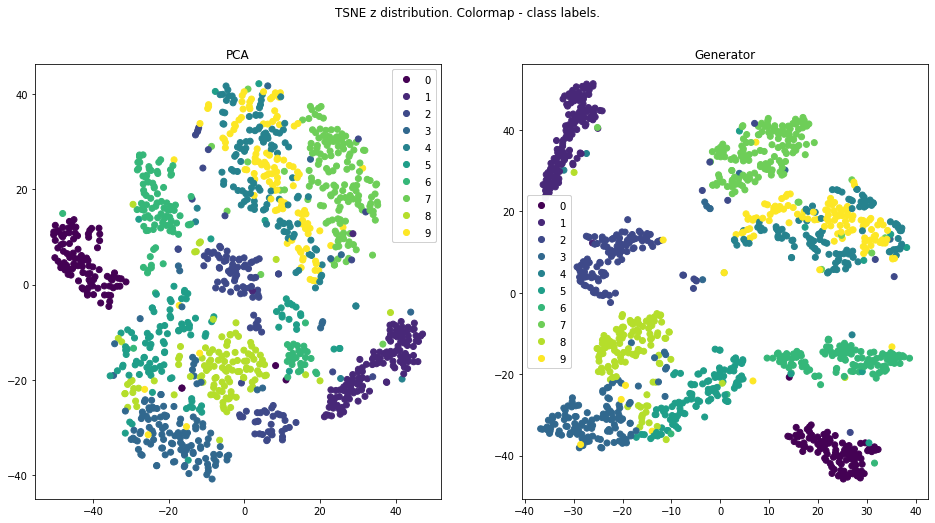

In [ ]:
step = 50
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('TSNE z distribution. Colormap - class labels.')

# PCA
z_pca = sample_generator.z_dataset[::step, :]
cmap = sample_generator.get_classes()[::step].tolist()
X_embedded = TSNE(n_components=2).fit_transform(z_pca)
scatter1 = ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)
legend1 = ax1.legend(*scatter1.legend_elements())
ax1.add_artist(legend1)
ax1.set_title('PCA')

# Generator learned distribution
z_model = model.z.weight.detach().cpu().numpy()[::step, :]
X_embedded = TSNE(n_components=2).fit_transform(z_model)
scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)
legend2 = ax2.legend(*scatter2.legend_elements())
ax2.add_artist(legend2)
ax2.set_title('Generator')

# fig.tight_layout()
plt.show()

## Calculate metrics

#### Models

In [ ]:
exp_name = 'no_sphere_alpha_0.9'
model_path = '/content/drive/MyDrive/GLANN/joint_mnist_models'

model.load_state_dict(torch.load(os.path.join(model_path, f'{exp_name}_generator_model.pth')))
flow.load_state_dict(torch.load(os.path.join(model_path, f'{exp_name}_flow_model.pth')))

<All keys matched successfully>

In [ ]:
def mnist_conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=5, padding='same'),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

def mnist_fc_block(in_features, out_features):
    return nn.Sequential(
        nn.Linear(in_features=in_features, out_features=out_features),
        nn.ReLU(),
        nn.Dropout(p=0.2)
    )

class MNISTModel(nn.Module):
    def __init__(self, n_classes):
        super(MNISTModel, self).__init__()
        self.feature_network = nn.Sequential(
            mnist_conv_block(1, 16),
            mnist_conv_block(16, 32),
            nn.Flatten(),
            mnist_fc_block(7*7*32, 256),
        )
        self.to_logits = nn.Linear(256, n_classes)

    def forward(self, input):
        return self.to_logits(self.feature_network(input))
    
    def features(self, input):
        return self.feature_network(input)

classifier = MNISTModel(10).to(device)
classifier.load_state_dict(torch.load('/content/drive/MyDrive/GLANN/classifiers/mnist_albu_model.pth'))

<All keys matched successfully>

#### Metrics

In [ ]:
def inputs_generator(size):
    normal_sample = torch.randn(size, N_COMPONENTS).to(device)
    fake_lats, _ = flow(normal_sample, rev=True)
    return fake_lats

def calc_classifier_features(generator, dataloader, inputs_generator, classifier):
    real_features = []
    fake_features = []
    fake_probs = []
    gen_device = next(iter(generator.parameters())).device
    for idx, real_img, _ in tqdm(dataloader, leave=False):
        bs = real_img.shape[0]
        if inputs_generator is None:
            idx = idx.long().to(gen_device)
            fake_img = generator(idx=idx).to(device)
        else:
            inputs = torch.nan_to_num(inputs_generator(bs), posinf=1, neginf=-1).to(gen_device)
            if torch.any(torch.isnan(inputs)):
                print(f'NaN samples occured: {inputs}')
            fake_img = generator(inputs=inputs).to(device)
        
        real_img = real_img.to(device)
        
        real_features_batch = classifier.features(real_img)
        real_features.append(real_features_batch.detach().cpu().numpy())   
        
        fake_features_batch = classifier.features(fake_img)
        fake_probs_batch = F.softmax(classifier.to_logits(fake_features_batch), dim=1)
        fake_features.append(fake_features_batch.detach().cpu().numpy())
        fake_probs.append(fake_probs_batch.detach().cpu().numpy())
        
    real_features = np.concatenate(real_features)
    fake_features = np.concatenate(fake_features)
    fake_probs = np.concatenate(fake_probs)

    return (real_features, 
            np.nan_to_num(fake_features, posinf=1, neginf=-1), 
            np.nan_to_num(fake_probs, posinf=0.5, neginf=-0.5))

In [ ]:
# fid, inception_score = val_loss(model, train_loader, inputs_generator)
# real_features, fake_features, fake_probs = val_loss.calc_data(model, sampler_init_train_loader, None)
fid = ValLoss.calc_fid(real_features, fake_features)
inception_score = ValLoss.calc_is(fake_probs)
print('FID and IS on Inception v3')
print(f'FID: {fid}\n IS: {inception_score}')

FID and IS on Inception v3
FID: 42.488615498201966
 IS: 2.6808547973632812


In [ ]:
inputs_generator(32)

tensor([[ 0.4753, -0.0594,  0.0305,  ...,  0.0479, -0.0086, -0.0588],
        [ 0.2957, -0.4564, -0.0825,  ...,  0.0593,  0.0053, -0.0029],
        [ 0.1916, -0.3989, -0.4539,  ..., -0.0014, -0.0302, -0.0119],
        ...,
        [-0.6387, -0.1527, -0.0579,  ...,  0.0748,  0.0277,  0.0399],
        [-0.4568,  0.3594, -0.2447,  ...,  0.0092,  0.0790,  0.0452],
        [-0.3322,  0.2160, -0.4607,  ..., -0.0306,  0.0298,  0.0384]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
real_features, fake_features, fake_probs = calc_classifier_features(model, sampler_init_train_loader, inputs_generator, classifier)
fid = ValLoss.calc_fid(real_features, fake_features)
inception_score = ValLoss.calc_is(fake_probs)
print('FID and IS on custom MNIST classifier')
print(f'FID: {fid}\n IS: {inception_score}')

  0%|          | 0/938 [00:00<?, ?it/s]

FID and IS on custom MNIST classifier
FID: 11.629402581126675
 IS: 9.734304428100586


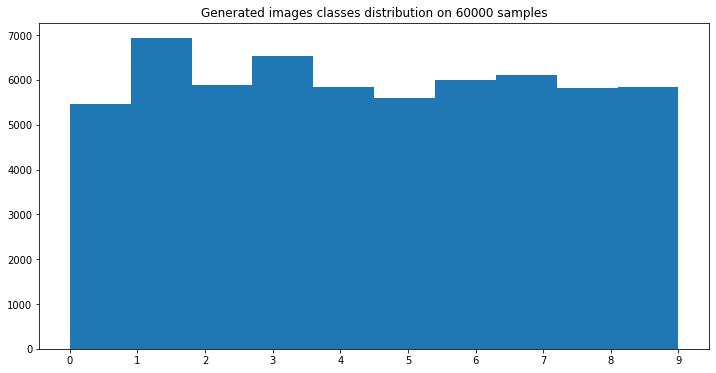

In [ ]:
classes = np.argmax(fake_probs, axis=1)
plt.figure(figsize=(12, 6))
plt.hist(classes, bins=10)
plt.title(f'Generated images classes distribution on {len(classes)} samples')
plt.xticks(np.unique(classes))
plt.show()

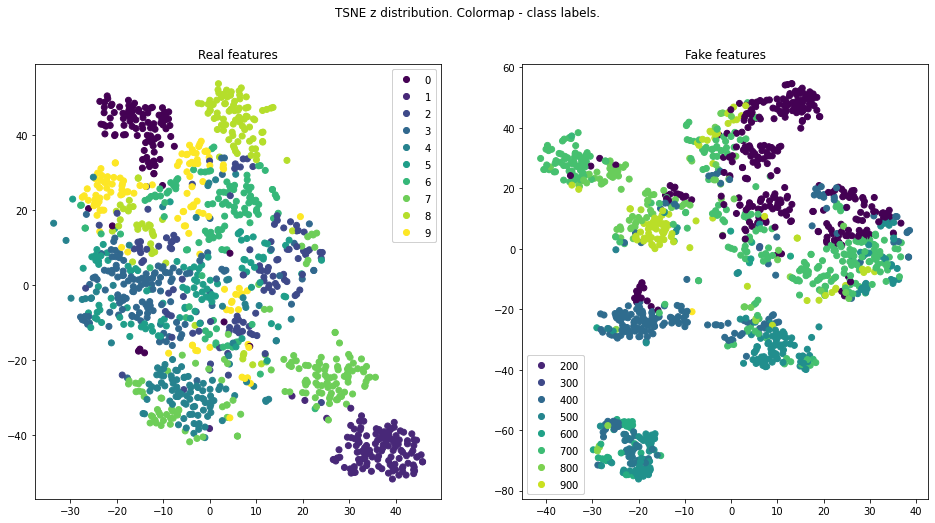

In [ ]:
step = 50
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('TSNE z distribution. Colormap - class labels.')

# PCA
cmap = sample_generator.get_classes()[::step].tolist()
X_embedded = TSNE(n_components=2).fit_transform(real_features[::step, :])
scatter1 = ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)
legend1 = ax1.legend(*scatter1.legend_elements())
ax1.add_artist(legend1)
ax1.set_title('Real features')

# Generator learned distribution
cmap = np.argmax(fake_probs, axis=1)[::step]
X_embedded = TSNE(n_components=2).fit_transform(fake_features[::step, :])
scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap)
legend2 = ax2.legend(*scatter2.legend_elements())
ax2.add_artist(legend2)
ax2.set_title('Fake features')

# fig.tight_layout()
plt.show()

### Inference with generator

In [ ]:
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator
from modules.dataset import IdxDataset

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
inverse_transform = tr.ToPILImage()

In [ ]:
mnist_train = MNIST(root='datasets', train=True, transform=tr.ToTensor(), download=True)

In [ ]:
mnist_train = IdxDataset(mnist_train)

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

In [ ]:
N_COMPONENTS = 32
BW_METHOD = 0.1
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator, sparse=True).to(device)

In [ ]:
model.load_state_dict(gen_state_dict)

<All keys matched successfully>

In [ ]:
base_distribution.sample(10).shape

torch.Size([10, 32])

In [ ]:
res = model(inputs=flow.sample(10))

In [ ]:
imgs = []
for tensor_res in res:
    img = inverse_transform(tensor_res)
    imgs.append(img)

In [ ]:
for img in imgs:
    plt.imshow(img)
    plt.show()

#### GLO article inference
Single full-covariance Gaussian fitted into the latents distribution

In [ ]:
inverse_transform = tr.ToPILImage()

In [ ]:
gm = GaussianMixture(n_components=1, covariance_type='full').fit(latents.cpu())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



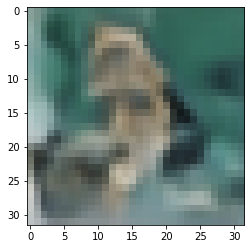

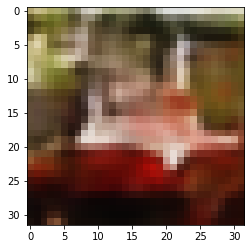

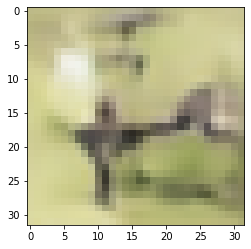

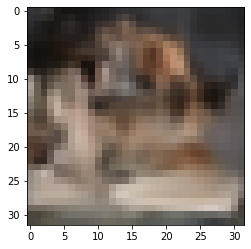

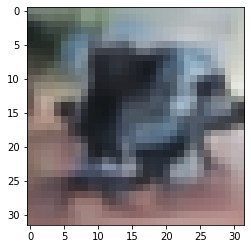

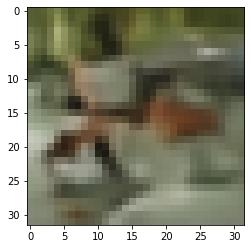

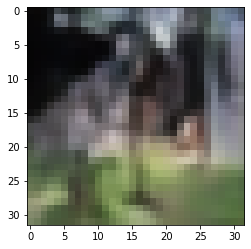

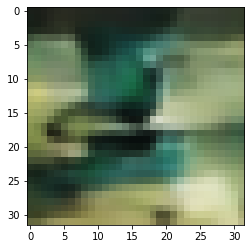

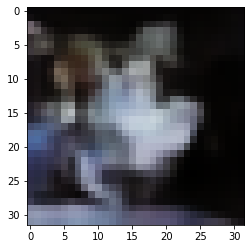

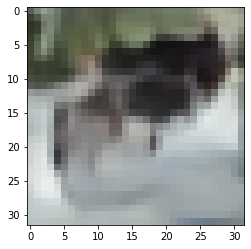

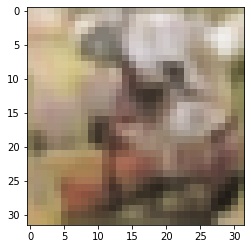

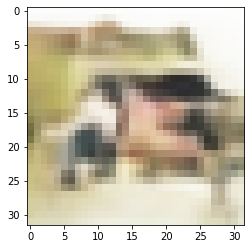

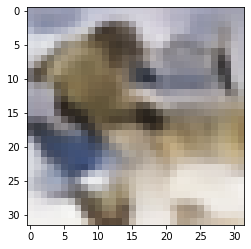

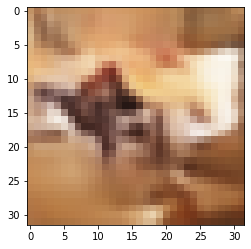

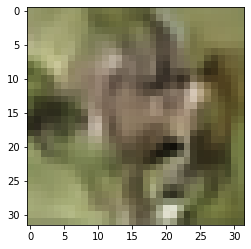

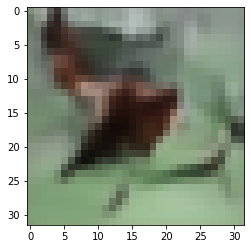

In [ ]:
gm_res = model(inputs=torch.tensor(gm.sample(16)[0], dtype=torch.float).to(device))
for tensor_res in gm_res:
    img = inverse_transform(tensor_res.to('cpu'))
    plt.imshow(img)
    plt.show()